In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from functions import loc2data, get_rand_locs
%matplotlib inline

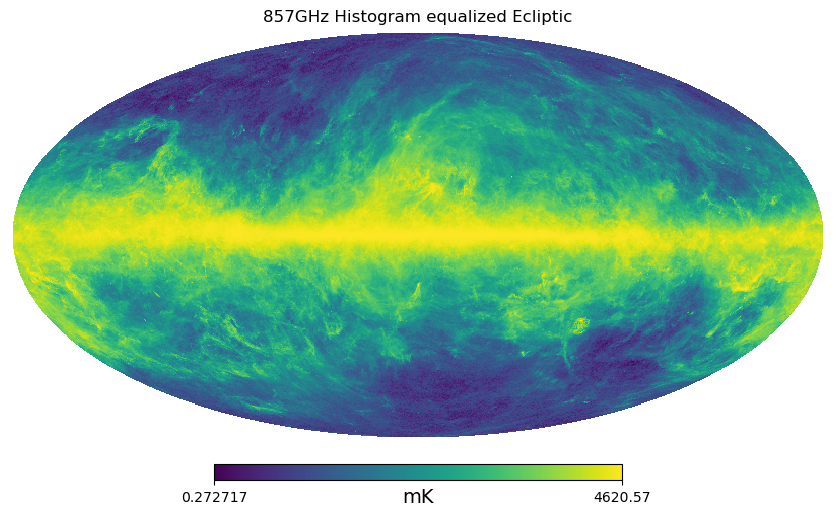

In [4]:
np.random.seed(100)

m_857 = hp.read_map("skymaps/HFI_SkyMap_857_2048_R1.10_nominal.fits")
nside = 1024
m_857 = hp.ud_grade(m_857, nside)
hp.mollview(
    m_857,
    #coord=["G", "E"],
    title="857GHz Histogram equalized Ecliptic",
    unit="mK",
    norm="hist")

In [5]:
# generate 1000 samples
num_locs = 1000
loc_list = get_rand_locs(num_locs, sphere_distr=True)

In [6]:
map_array = np.copy(m_857)
circ_radius = np.pi / 180
cutout_radius = circ_radius / 10

# currently we are cutting out 1-degree circles
# it always stores to 82x82 array
annulus_images = []
source_images = []

for loc in loc_list:
    loc_deg = np.rad2deg(loc)
    loc_pix = hp.ang2pix(nside, *loc_deg, lonlat=True)
    annulus_2d, source_2d = loc2data(map_array, loc, circ_radius, cutout_radius, show_gnomview=False)
    annulus_images.append(annulus_2d)
    source_images.append(source_2d)

complete_images = np.array(annulus_images) + np.array(source_images)

In [7]:
complete_images.shape

(1000, 82, 82)

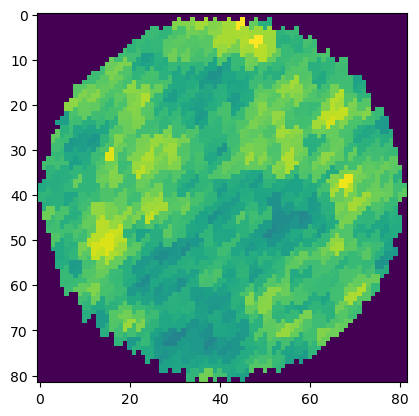

In [8]:
plt.imshow(complete_images[0])

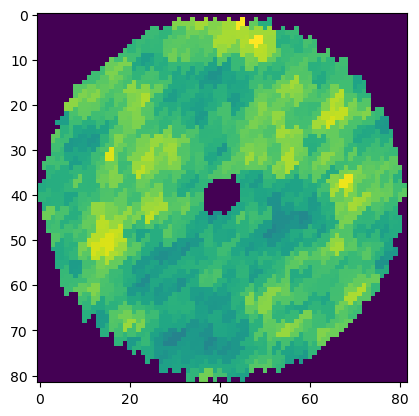

In [9]:
plt.imshow(annulus_images[0])

In [10]:
x = np.arange(82) - 40.5
y = np.arange(82) - 40.5
xv, yv = np.meshgrid(x, y)
print(np.array([xv,yv]).T.shape)

(82, 82, 2)


In [11]:
mask_1 = (xv**2+yv**2)<20**2
mask_2 = (xv**2+yv**2)<5**2

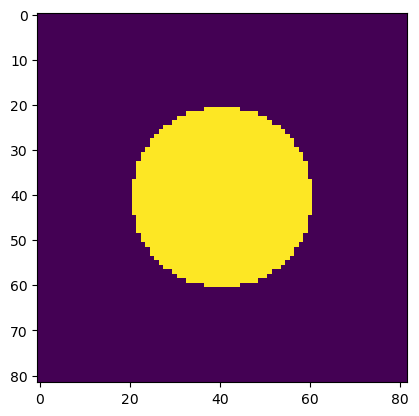

In [12]:
plt.imshow(mask_1)

In [13]:
complete_images.shape

(1000, 82, 82)

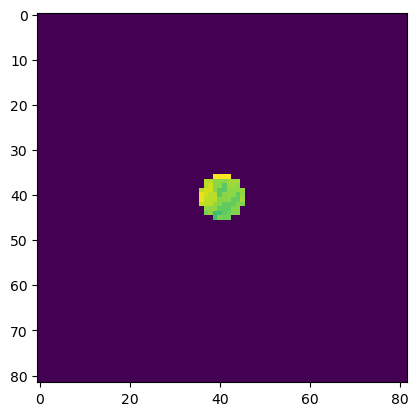

In [14]:
plt.imshow(complete_images[0]*mask_2)

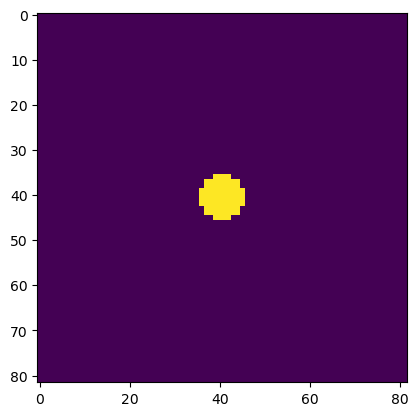

In [15]:
plt.imshow(mask_2)

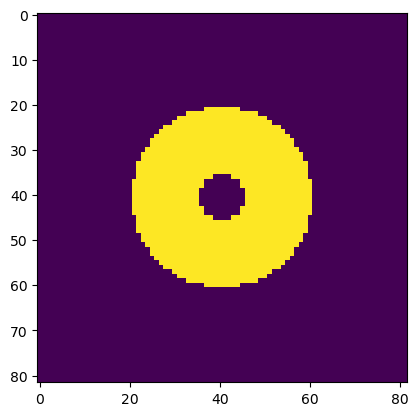

In [16]:
plt.imshow(mask_1*~mask_2)
mask_3 = mask_1*~mask_2

In [17]:
# package this into training set:
# - an array
# - a truth number
# - a aperture photometry number 

Training = []
Label = []
Aper_phot = []
Complete = []
Source = []
Source_masks = []

for i in range(1000):
    Training.append(complete_images[i]*mask_3)
    Label.append(np.mean(complete_images[i][mask_2]))
    Aper_phot.append(np.mean(complete_images[i][mask_3]))
    Complete.append(complete_images[i]*mask_1)
    Source.append(complete_images[i]*mask_2)
    Source_masks.append(mask_2)
    

In [18]:
# save the training set
np.savez('training_inpainter_20240703.npz', 
         data=np.array(Training), label=np.array(Label), estimate=np.array(Aper_phot), 
        mask_data=mask_3, mask_label=mask_2, complete = np.array(Complete), source = np.array(Source), source_masks=np.array(Source_masks))

Text(0, 0.5, 'mean estimated from aperature photometry')

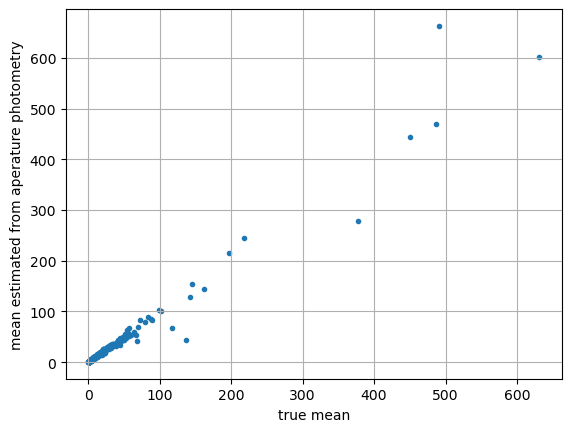

In [19]:
plt.scatter(Label, Aper_phot, marker='.')
plt.grid()
plt.xlabel('true mean')
plt.ylabel('mean estimated from aperature photometry')

In [20]:
training = np.load('training_inpainter_20240703.npz')